# BSD68 Denoising Dataset

In [1]:
# Torch
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim 
from torchsummary import summary
from torchvision.transforms import v2


# Train + Data 
import sys 
sys.path.append('../Layers')
from Conv1d_NN import *
from Conv2d_NN import *
from Conv1d_NN_spatial import * 

from Conv2d_NN_spatial import * 
from ConvNN_CNN_Branching import *

sys.path.append('../Data')
from BSD68 import * 
from CIFAR10 import *


sys.path.append('../Models')
from denoising_models import * 

sys.path.append('../Train')
from train2d import * 



import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

import torch 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets


/Users/mingikang/miniforge3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NoisyBSD68(Dataset):
    def __init__(self, 
                 target_count=5000,
                 noise_std=0.3
                 ):
        
        super(NoisyBSD68, self).__init__()
        self.noise_std = noise_std
        
        self.images = self.load_images("/Users/mingikang/Developer/Convolutional-Nearest-Neighbor/Data/BSD68_data")
        self.data = self.create_image_set(self.images, target_count)
        
    def __getitem__(self, index):
        img, target = self.data[index], self.data[index]
        
        # # Add noise v1
        # noisy_img = img + self.noise_std * torch.randn_like(img)
        # noisy_img = torch.clamp(noisy_img, 0, 1)
        
        ####
        
        # # Add Noise v2
        # add_gaussian_noise = transforms.GaussianBlur(sigma=self.noise_std)
        # noisy_img = add_gaussian_noise(img)
        
        # # Add Noise v3
        # blurrer = v2.GaussianBlur(kernel_size=(15, 15), sigma=(self.noise_std))
        # noisy_img = blurrer(img)
        
        
        # # Add Noise v4
        noise = torch.randn(img.size()).mul_(self.noise_std/255.0)
        noisy_img = img + noise        
        
        return noisy_img, img, target
    

    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def load_images(directory):
        images = []
        
        for filename in os.listdir(directory):
            try: 
                img = Image.open(os.path.join(directory, filename)).convert('L')  # Convert to grayscale
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                img_array = torch.from_numpy(img_array).float()
                images.append(img_array)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
            
        return images

    @staticmethod
    def create_image_set(images, target_count, target_size=200):
        
        image_set = []
        
        for i in range(target_count):
            img = random.choice(images)
            img = img.unsqueeze(0)  # Add batch dimension

            transform_list = [transforms.RandomCrop(target_size)]
            
            if random.random() > 0.3:  # 30% chance of flipping
                transform_list.append(transforms.RandomHorizontalFlip(p=1.0))  # p=1.0 means always flip
            
            if random.random() > 0.3:  # 30% chance of flipping
                transform_list.append(transforms.RandomVerticalFlip(p=1.0))  # p=1.0 means always flip
                
            rotational_angles = [90, 180, 270]
            if random.random() > 0.3: # 30% chance of rotating
                rotation_angle = random.choice(rotational_angles)
                transform_list.append(transforms.RandomRotation(degrees=(rotation_angle, rotation_angle)))

            transform = transforms.Compose(transform_list)
            transformed_img = transform(img)
            image_set.append(transformed_img)  # Remove batch dimension
            
        return image_set
    
    @staticmethod
    def visual(data, n=1): 
        plt.figure(figsize=(12, 6))
        for i in range(n):
            img = data[i]
            
            # Display original image
            plt.subplot(2, n, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title("Original")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        


class NoisyBSD68_dataset:
    def __init__(self, 
                 batch_size=64,
                 noise_std=0.3):
        
        self.batch_size = batch_size
        
        
        self.train_data = NoisyBSD68(target_count=200, noise_std=noise_std)
        self.test_data = NoisyBSD68(target_count=40, noise_std=noise_std)
        
        self.train_loader = DataLoader(dataset=self.train_data, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(dataset=self.test_data, batch_size=batch_size, shuffle=True)
        
    def shape(self):    
        return self.train_data[0][0].shape
    
    def visual(self, n=5): 
        plt.figure(figsize=(12, 6))
        for i in range(n):
            noisy_img, img, _ = self.test_data[i]
            noisy_img = noisy_img.squeeze(0)
            img = img.squeeze(0)
            
            # Display original image
            plt.subplot(2, n, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title("Original")
            plt.axis('off')

            # Display noisy image
            plt.subplot(2, n, n + i + 1)
            plt.imshow(noisy_img, cmap='gray')
            plt.title("Noisy")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        

In [8]:
def test_denoise_visual(model, test_data, n=3):
    fig, axes = plt.subplots(n, 3, figsize=(15, 5*n))
    
    for i in range(n):
        noisy_img, img, _ = test_data[i]
        
        # Remove batch dimension and any extra dimensions
        noisy_img = noisy_img.squeeze(0)
        img = img.squeeze(0)
        
        # Display original clean image
        axes[i, 0].imshow(img.cpu().numpy(), cmap='gray')
        axes[i, 0].set_title("Original Clean", fontsize=22)
        axes[i, 0].axis('off')

        # Display noisy image
        axes[i, 1].imshow(noisy_img.cpu().numpy(), cmap='gray')
        axes[i, 1].set_title("Noisy", fontsize=22)
        axes[i, 1].axis('off')
        
        # Generate and display denoised image
        model.eval()
        with torch.no_grad():
            denoised_img = model(noisy_img.unsqueeze(0).unsqueeze(0).to("mps"))
            denoised_img = denoised_img.squeeze().cpu().numpy()
            axes[i, 2].imshow(denoised_img, cmap='gray')
            axes[i, 2].set_title("Denoised", fontsize=22)
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [17]:
noisybsd68 = NoisyBSD68_dataset(batch_size=32, noise_std=75)

In [18]:
print(len(noisybsd68.train_data))
print(len(noisybsd68.test_data))
print(len(noisybsd68.test_data[0]))
print(noisybsd68.train_data[0][0].shape)


200
40
3
torch.Size([1, 200, 200])


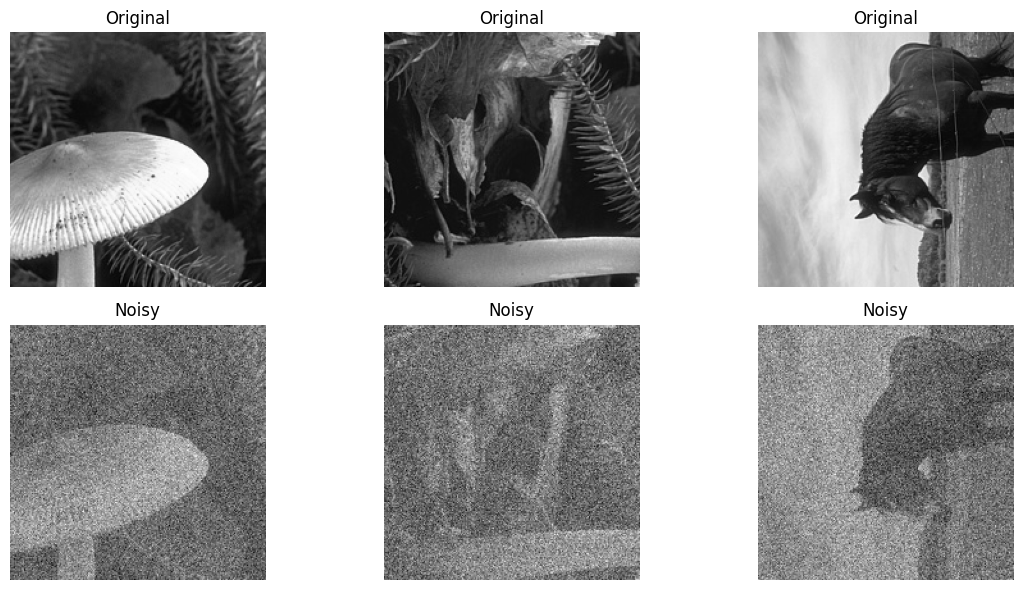

In [19]:
noisybsd68.visual(3)

### Control CNN Model



Epoch 1, Time: 0.6252317428588867, Loss: 0.06663972299013819
Epoch 2, Time: 0.350614070892334, Loss: 0.024298460888011113
Epoch 3, Time: 0.3452470302581787, Loss: 0.015518871668194021
Epoch 4, Time: 0.34824109077453613, Loss: 0.01123571622052363
Epoch 5, Time: 0.34988903999328613, Loss: 0.010325370755578791
Epoch 6, Time: 0.34035825729370117, Loss: 0.009336920455098152
Epoch 7, Time: 0.34639525413513184, Loss: 0.009211551531084947
Epoch 8, Time: 0.3443031311035156, Loss: 0.008769185880997352
Epoch 9, Time: 0.3474910259246826, Loss: 0.008870119095913
Epoch 10, Time: 0.34654688835144043, Loss: 0.00855693154569183

 Average epoch time: 0.37443175315856936
Average loss on test set: 0.008292108308523893
Average PSNR on test set: 21.066277503967285


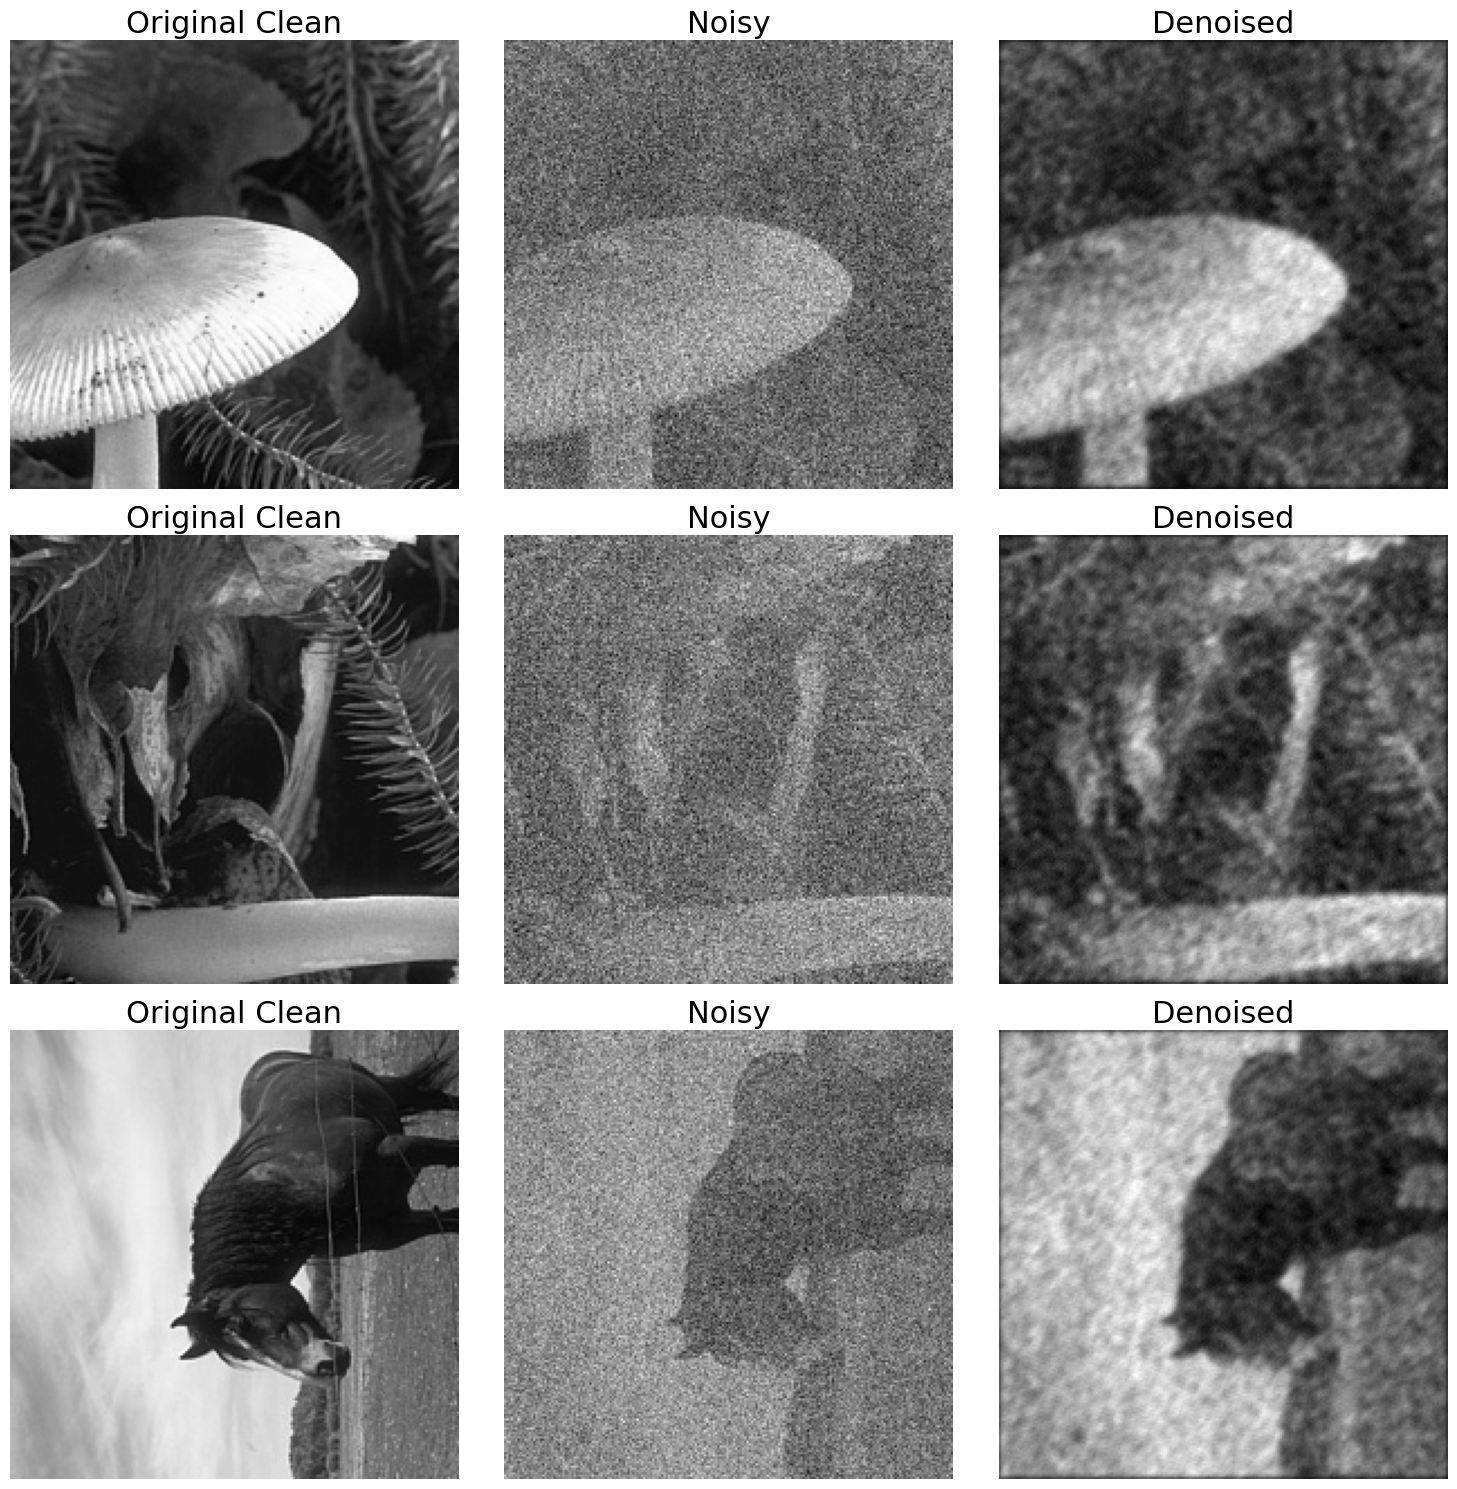

In [20]:
# CNN control model 
CNN = DenoisingCNN(in_ch=1, out_ch=1, kernel_size=3)

criterion = nn.MSELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)
num_epochs = 10
train_denoising_model(CNN, noisybsd68.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(CNN, noisybsd68.test_loader, criterion)
evaluate_accuracy_psnr(CNN, noisybsd68.test_loader, criterion)


# Print out output of trained model
test_denoise_visual(CNN, noisybsd68.test_data)


## Branching Model

Epoch 1, Time: 8.86014175415039, Loss: 0.8305738823754447
Epoch 2, Time: 5.414492845535278, Loss: 0.8026239701679775
Epoch 3, Time: 5.448463201522827, Loss: 0.7802376747131348
Epoch 4, Time: 5.517998933792114, Loss: 0.7890077914510455
Epoch 5, Time: 5.491619110107422, Loss: 0.7734165361949376
Epoch 6, Time: 5.397324085235596, Loss: 0.7656780055591038
Epoch 7, Time: 5.434603929519653, Loss: 0.7515290720122201
Epoch 8, Time: 5.378098964691162, Loss: 0.7363607713154384
Epoch 9, Time: 5.431323766708374, Loss: 0.7336648276873997
Epoch 10, Time: 5.520608186721802, Loss: 0.7156592692647662

 Average epoch time: 5.789467477798462
Average loss on test set: 0.6896198093891144
Average PSNR on test set: 1.7311911582946777


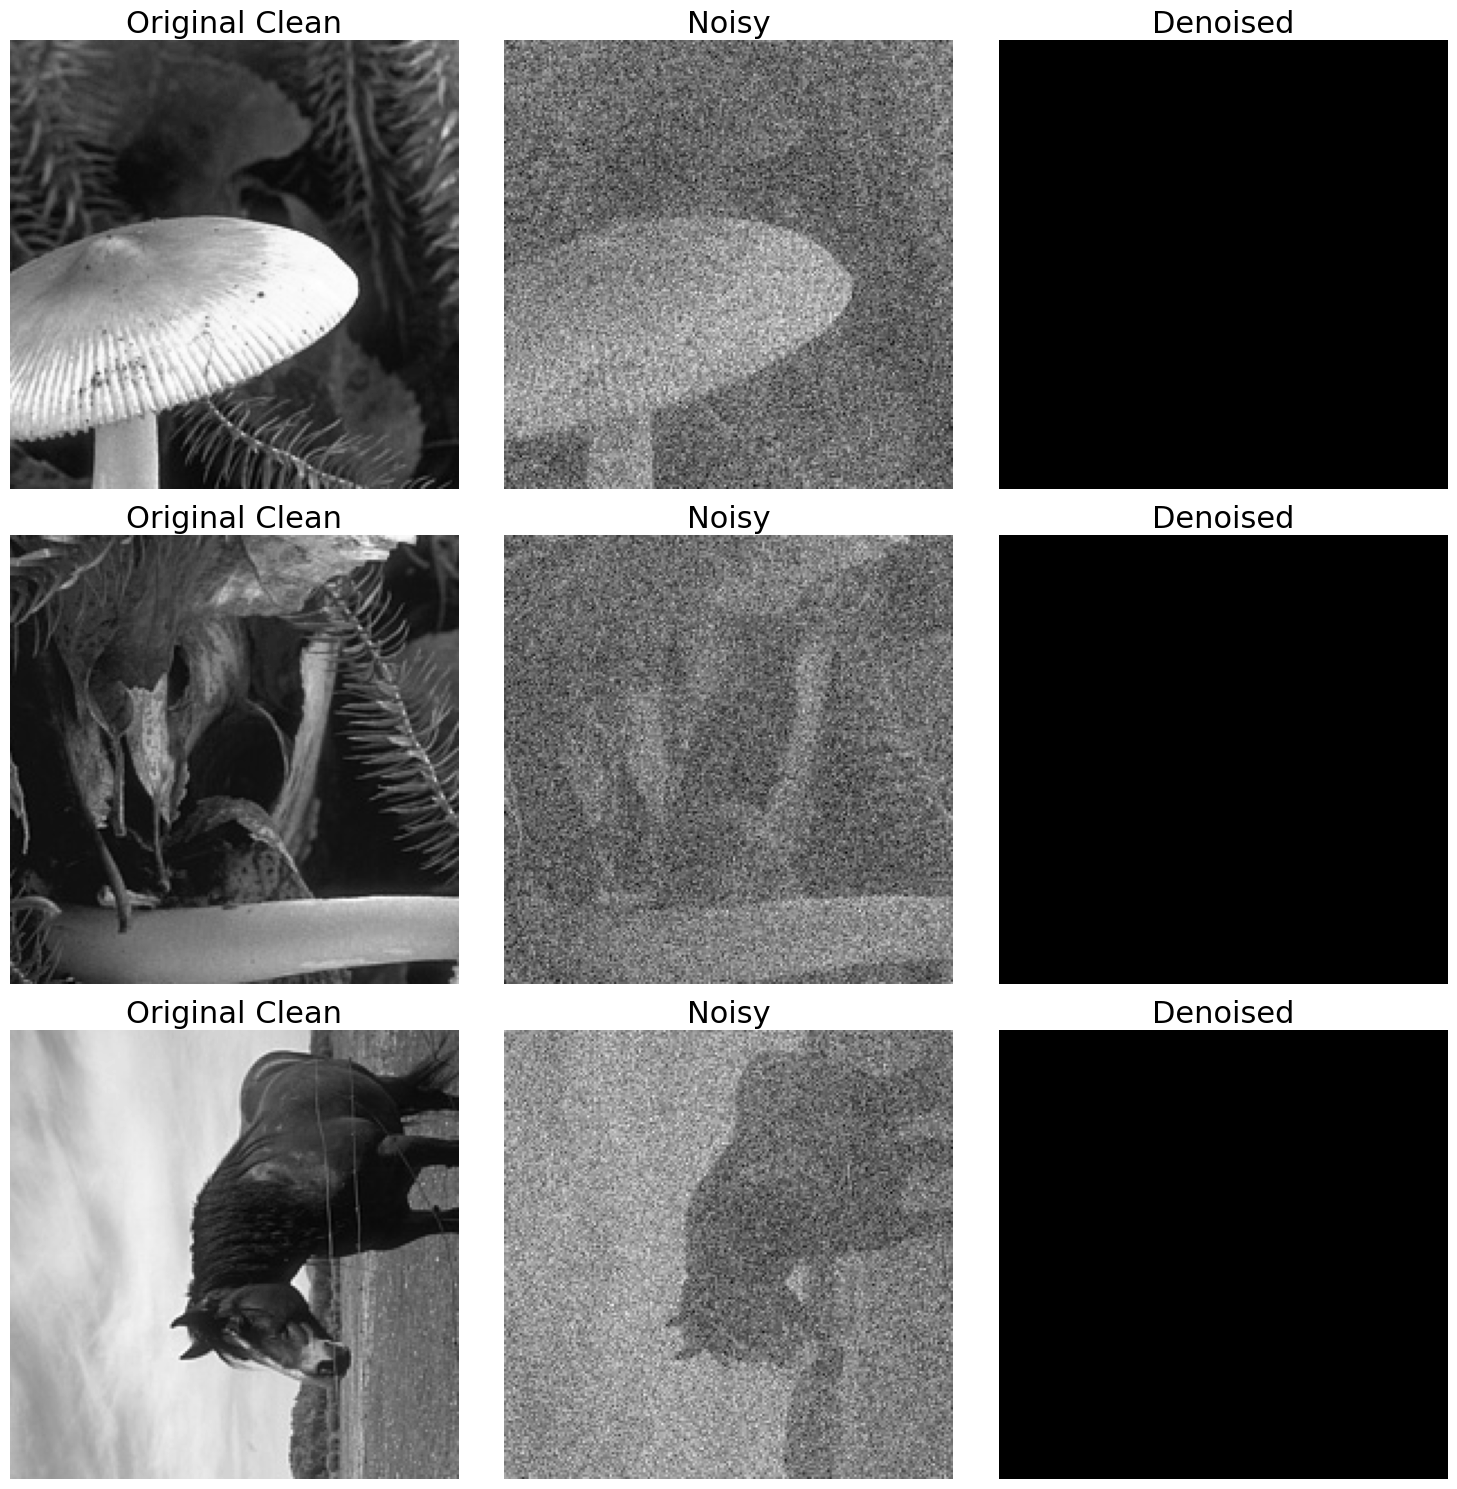

In [ ]:
# Denoising Branching CNN + ConvNN Spatial, K = 9, N = 8 (64), 16:1
denoisingbranching_convNN_spatial_K_N_16_16 = DenoisingBranching_ConvNN_2D_Spatial_K_N(in_ch=1, out_ch=1, K=3, N=5)

criterion = nn.MSELoss()
optimizer = optim.Adam(denoisingbranching_convNN_spatial_K_N_16_16.parameters(), lr=0.001)
num_epochs = 10
train_denoising_model(denoisingbranching_convNN_spatial_K_N_16_16, noisybsd68.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(denoisingbranching_convNN_spatial_K_N_16_16, noisybsd68.test_loader, criterion)
evaluate_accuracy_psnr(denoisingbranching_convNN_spatial_K_N_16_16, noisybsd68.test_loader, criterion)

# Print out output of trained model
test_denoise_visual(denoisingbranching_convNN_spatial_K_N_16_16, noisybsd68.test_data)



## ERROR spatial branching is not working now -> figure out why



Epoch 1, Time: 12.627522706985474, Loss: 0.05302469113043377
Epoch 2, Time: 12.502223014831543, Loss: 0.03437273842947824
Epoch 3, Time: 11.867409944534302, Loss: 0.019623101821967533
Epoch 4, Time: 11.33554196357727, Loss: 0.017781059922916547
Epoch 5, Time: 10.300354242324829, Loss: 0.01564595103263855
Epoch 6, Time: 10.100369215011597, Loss: 0.012274680792221002
Epoch 7, Time: 9.90149998664856, Loss: 0.011613076286656516
Epoch 8, Time: 9.600290060043335, Loss: 0.011368159470813615
Epoch 9, Time: 10.767893075942993, Loss: 0.010605900016214167
Epoch 10, Time: 10.842960119247437, Loss: 0.010815220618886607

 Average epoch time: 10.984606432914735
Average loss on test set: 0.009065409423783422
Average PSNR on test set: 20.501523971557617


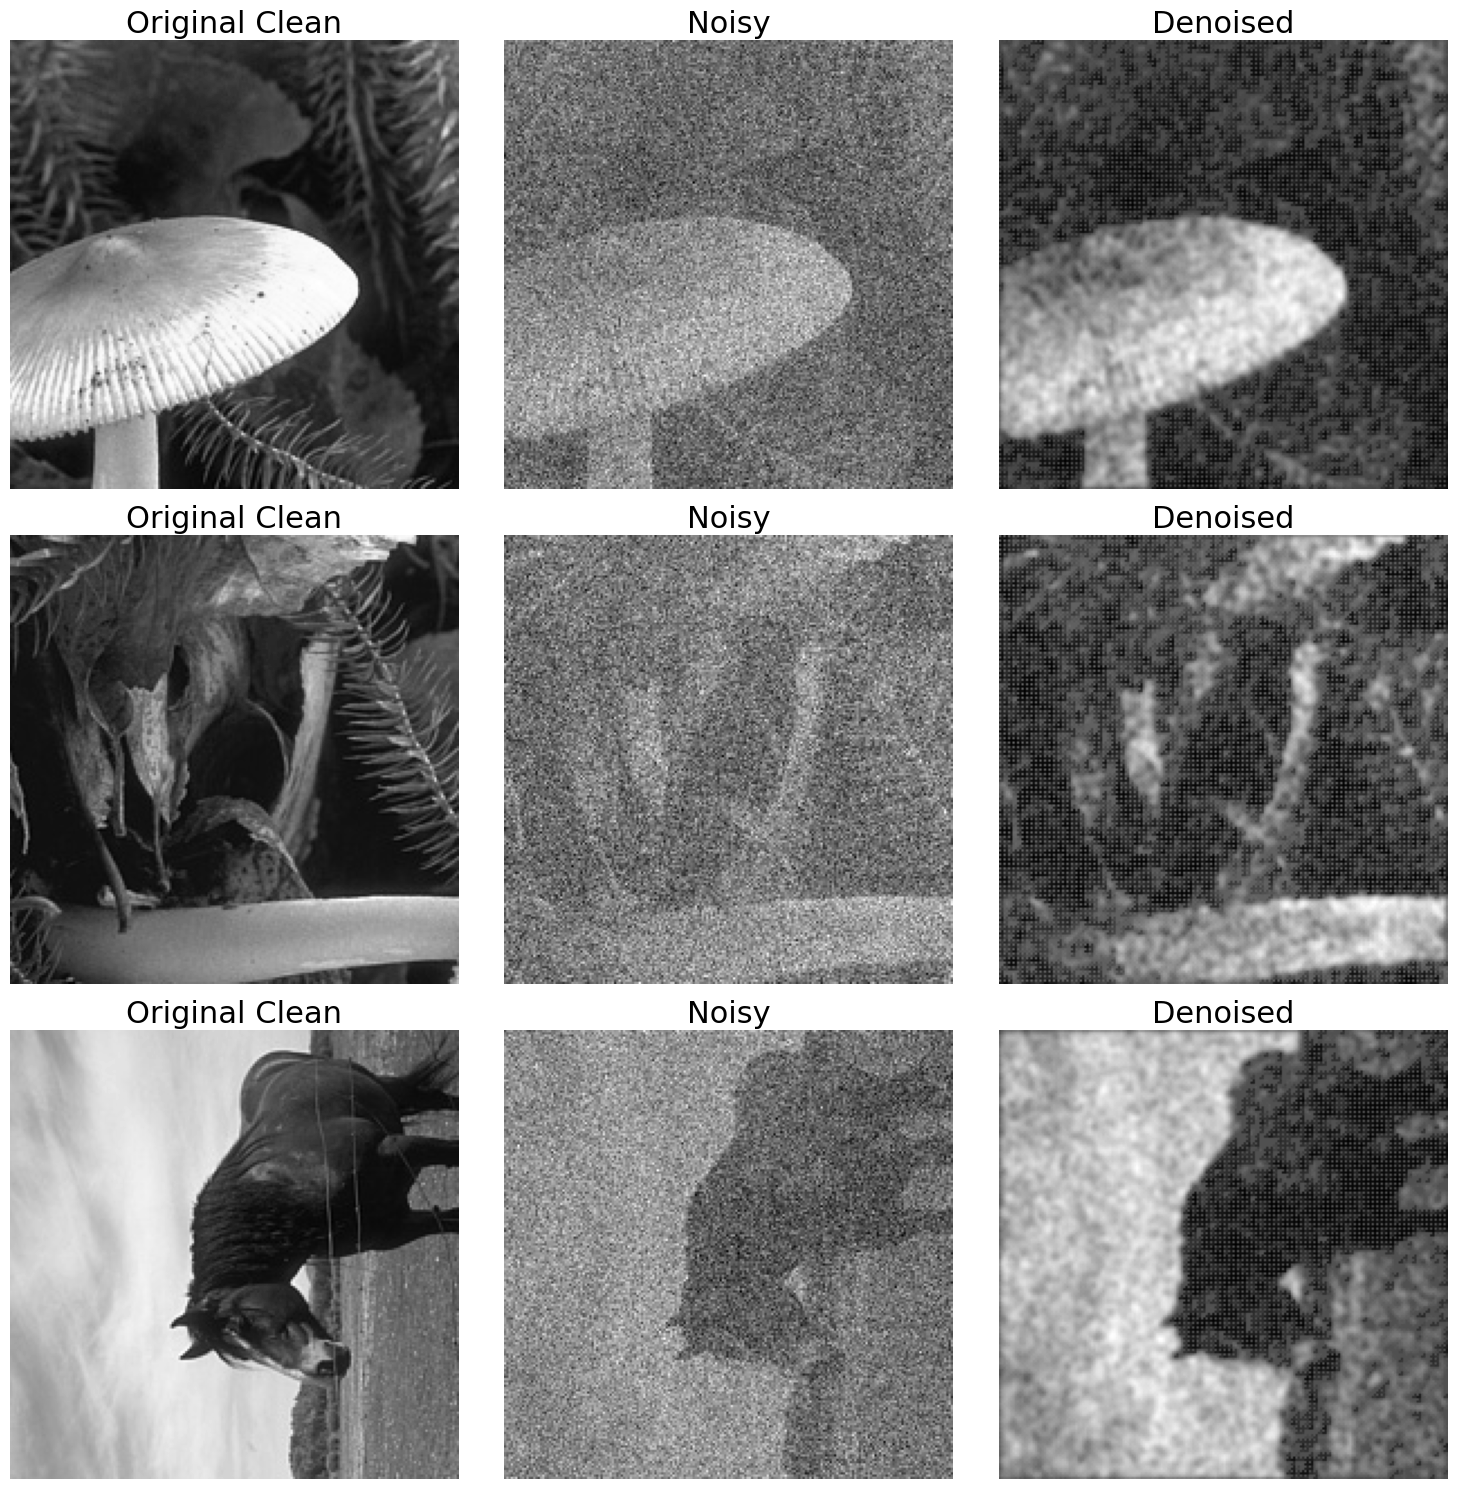

In [23]:
# Denoising Branching CNN + ConvNN Spatial, K = 9, N = 8 (64), 16:1
denoisingbranching_convNN_K_N_16_16 = DenoisingBranching_ConvNN_2D_K_N(in_ch=1, out_ch=1, K=3, N=25)

criterion = nn.MSELoss()
optimizer = optim.Adam(denoisingbranching_convNN_K_N_16_16.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(denoisingbranching_convNN_K_N_16_16, noisybsd68.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(denoisingbranching_convNN_K_N_16_16, noisybsd68.test_loader, criterion)
evaluate_accuracy_psnr(denoisingbranching_convNN_K_N_16_16, noisybsd68.test_loader, criterion)

# Print out output of trained model
test_denoise_visual(denoisingbranching_convNN_K_N_16_16, noisybsd68.test_data)



Epoch 1, Time: 16.074393033981323, Loss: 0.1117125887955938
Epoch 2, Time: 24.412824153900146, Loss: 0.055212777107954025
Epoch 3, Time: 11.979904174804688, Loss: 0.040918288486344476
Epoch 4, Time: 11.015564203262329, Loss: 0.03301191835531166
Epoch 5, Time: 11.580481052398682, Loss: 0.02742932124861649
Epoch 6, Time: 11.561722040176392, Loss: 0.023375122674873898
Epoch 7, Time: 11.792755842208862, Loss: 0.021331876516342163
Epoch 8, Time: 11.888868808746338, Loss: 0.02108342173908438
Epoch 9, Time: 11.45395302772522, Loss: 0.019871626581464494
Epoch 10, Time: 11.830980777740479, Loss: 0.01929894382400172

 Average epoch time: 13.359144711494446
Average loss on test set: 0.020481528714299202
Average PSNR on test set: 17.228851318359375


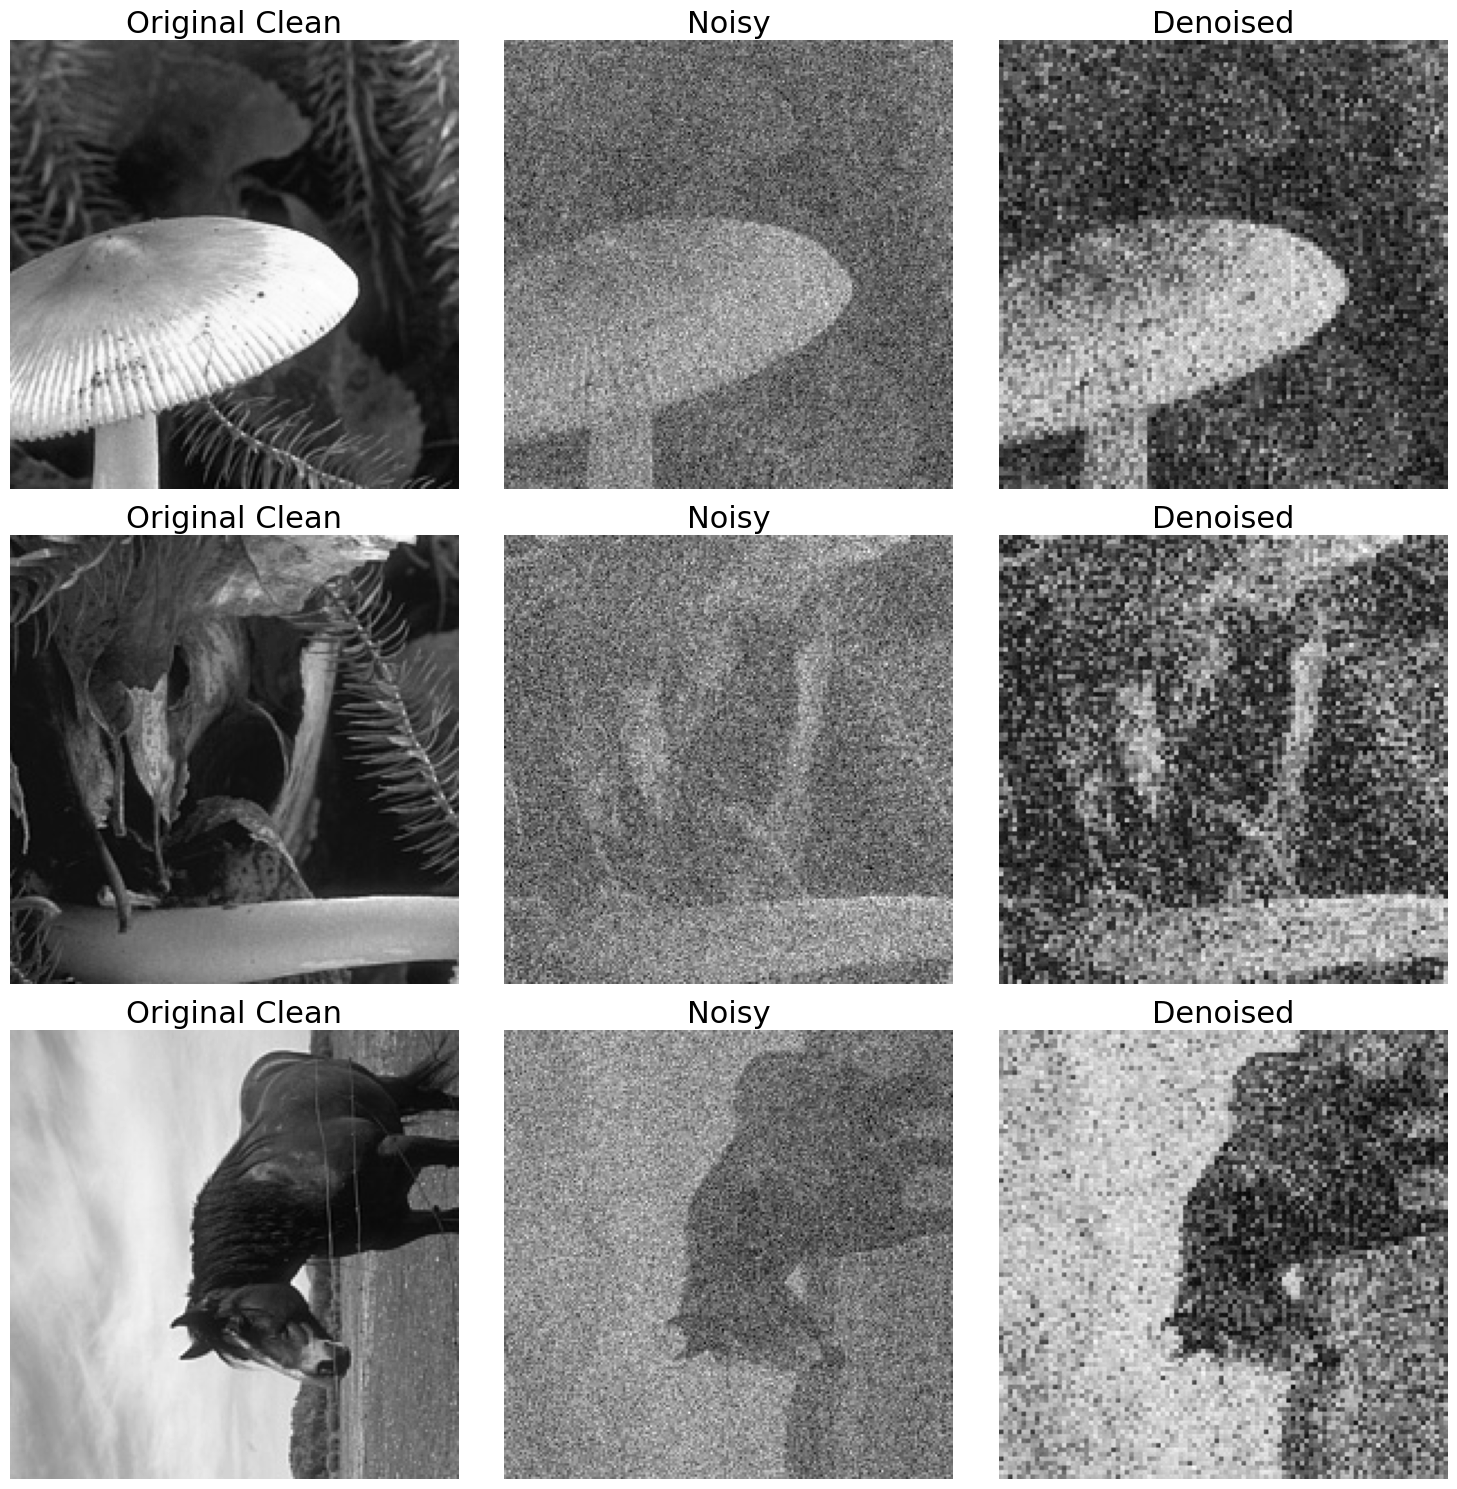

In [24]:
# ConvNN K = 3, N = 25
denoising_convNN_2D_K_N = DenoisingConvNN_2D_K_N(in_ch=1, out_ch=1, K=3, N=25)

criterion = nn.MSELoss()
optimizer = optim.Adam(denoising_convNN_2D_K_N.parameters(), lr=0.001)
num_epochs = 10 
train_denoising_model(denoising_convNN_2D_K_N, noisybsd68.train_loader, criterion, optimizer, num_epochs)
evaluate_denoising_accuracy(denoising_convNN_2D_K_N, noisybsd68.test_loader, criterion)
evaluate_accuracy_psnr(denoising_convNN_2D_K_N, noisybsd68.test_loader, criterion)

# Print out output of trained model
test_denoise_visual(denoising_convNN_2D_K_N, noisybsd68.test_data)

